<h1>1. The NBA Career Prediction</h1>

<p>This .ipynb is designed to train a Random Forest model using the provided file 2022_train.csv to predict the probability of an NBA rookie player will last at least 5 years in the league based on its stats. </p> 
<p> In this notebook, I have implemented SMOTE and will continue to finetune the random forest algorithm.


In [625]:
"""
The NBA Career Prediction - assignment 3
Team member: Olivia Dewi, Federico Gonzales, Tim Wang
"""
import csv
import numpy as np
import pandas as pd
import os
import joblib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from IPython.display import display, HTML
from math import log
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from joblib import dump
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import warnings
warnings.filterwarnings("ignore")

The scikit-learn version is 1.1.3.


<h1>2. We are provided with three sets of datasets, namely:</h1>
<p> a) training data <p> b) test data  <p> c) sample submission

<h4> Let's load all of them </h4>

In [626]:
#The training data
trainingdata =  pd.read_csv("../data/raw/2022_train.csv")

In [627]:
#The test data
testdata = pd.read_csv("../data/raw/2022_test.csv")

In [628]:
#The sample submission
sample = pd.read_csv("../data/raw/2022_sample_submission.csv")

<h1>3. Data exploration </h1>

<h2> 3.1 Let's look at what columns we have in the three datasets </h2>

In [629]:
print("Training data columns are: ") 
trainingdata.columns


Training data columns are: 


Index(['Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'TARGET_5Yrs'],
      dtype='object')

In [630]:
print("Test data columns are: ") 
testdata.columns


Test data columns are: 


Index(['Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV'],
      dtype='object')

In [631]:
# Display the first 5 lines in the trainingdata
trainingdata.head()

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [632]:
trainingdata.shape

(8000, 21)

In [633]:
print("Sample submission columns are: ") 
sample.columns

Sample submission columns are: 


Index(['Id', 'TARGET_5Yrs'], dtype='object')

<h4>Explanations on the data fields:</h4>

<p>Id - Player Identifier</p>
<p>GP - Games Played</p>
<p>MIN - Minutes Played</p>
<p>PTS - Points Per Game</p>
<p>FGM - Field Goals Made</p>
<p>FGA - Field Goals Attempts</p>
<p>FG% - Field Goals Percent</p>
<p>3P Made - 3-Points Made</p>
<p>3PA - 3-Points Attempts</p>
<p>3P% - 3-Points Percent</p>
<p>FTM - Free Throw Made</p>
<p>FTA - Free Throw Attempts</p>
<p>FT% - Free Throw Percent</p>
<p>OREB - Offensive Rebounds</p>
<p>DREB - Defensive Rebounds</p>
<p>REB - Rebounds</p>
<p>AST - Assists</p>
<p>STL - Steals</p>
<p>BLK - Blocks</p>
<p>TOV - Turnovers</p>
<p>TARGET_5Yrs - Outcome: 1 if career length >= 5 years, 0 otherwise</p>

In [634]:
#Let's explore the correlation of the columns in the training set
def confusionmatrix(data):
    plt.figure(figsize=(20, 8))
    mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
    heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

Training data confusion matrix


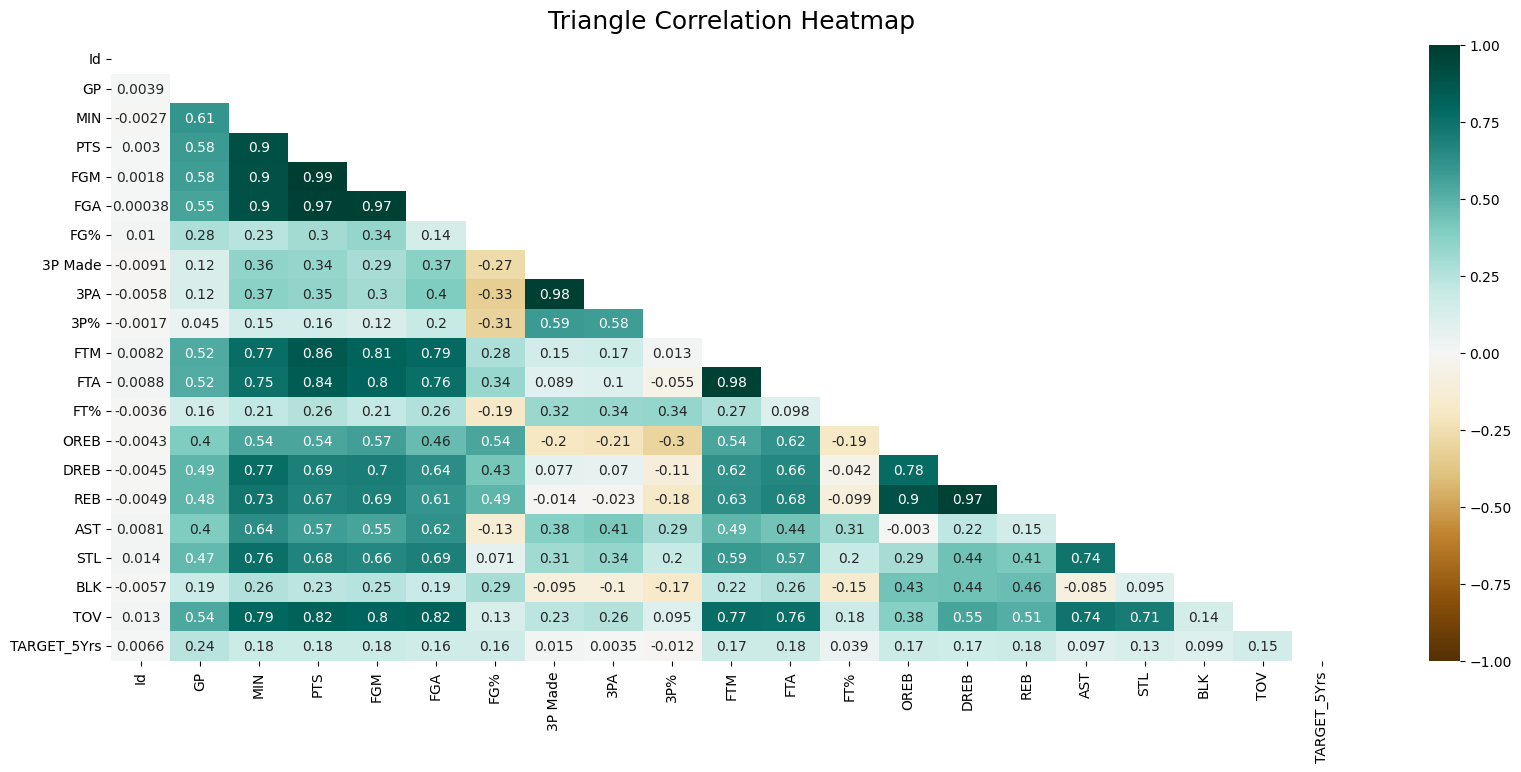

In [635]:
print('Training data confusion matrix')
confusionmatrix(trainingdata)

Test data confusion matrix


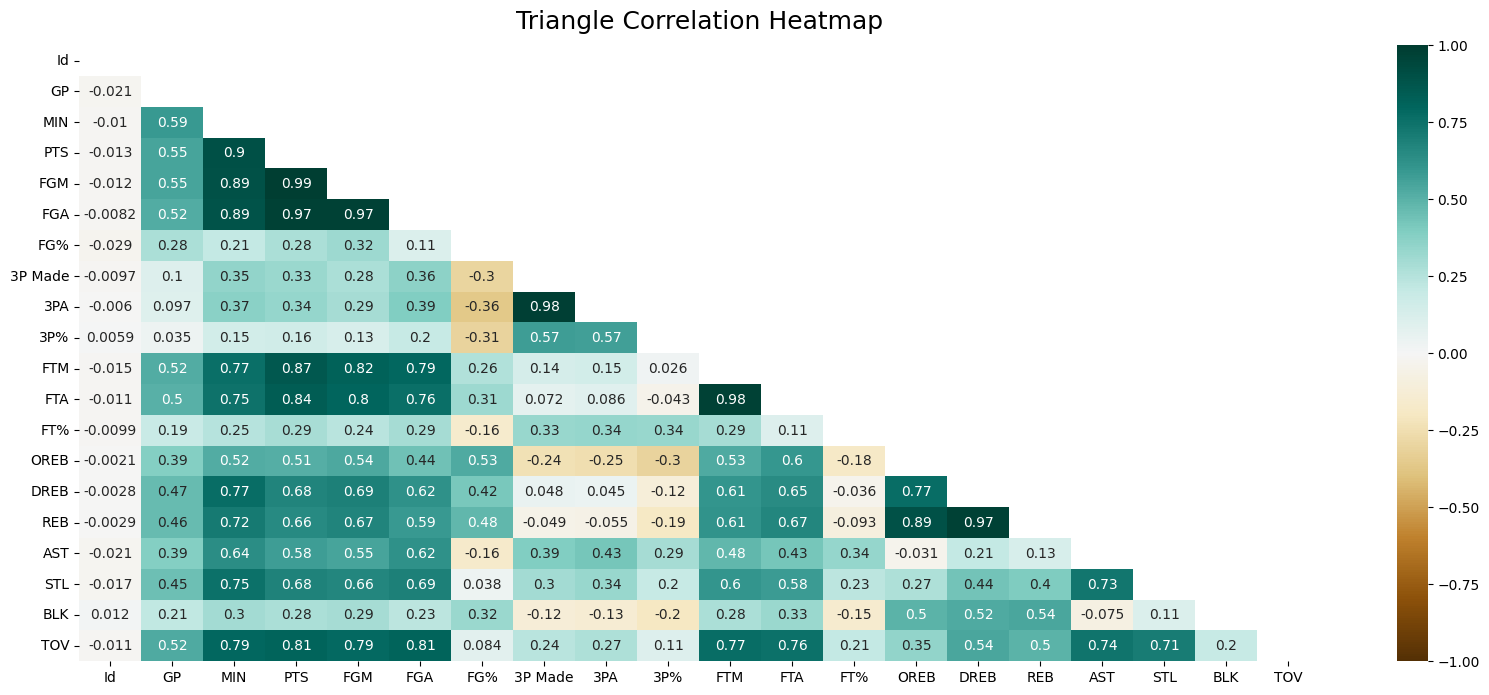

In [636]:
print('Test data confusion matrix')
confusionmatrix(testdata)

<h2> 3.1: Conclusion </h2>
<p>    a) Looking at the correlation heatmap, it looks like the correlation relationship between columns between the training data and test data is very similar <p>
<p>    b) Player ID should be used as the index as it is merely the identifier, and our target column is not correlated to this column <p>

In [637]:
#But first, let's copy the training data and test data
trainingdata_cleaned = trainingdata.copy()

In [638]:
#Now we can set the column 'Id' as the index
trainingdata_cleaned.set_index(['Id'], inplace = True)

In [639]:
trainingdata_cleaned.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,62.777875,18.576662,7.267088,2.807037,6.231212,44.608900,0.264525,0.816562,19.583700,1.392525,1.947788,71.365825,1.077838,2.168500,3.245300,1.624513,0.648687,0.245212,1.257763,0.833625
std,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,16.003155,0.926153,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,-38.500000,0.000000,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,1.200000,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,1.900000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,8.100000,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [640]:
trainingdata_cleaned.columns = trainingdata_cleaned.columns.str.strip()

In [641]:
trainingdata_cleaned.columns

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM',
       'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'TARGET_5Yrs'],
      dtype='object')

In [642]:
#Would normalising the data work better on the dataset?
#Let's normalised the data
def normalised(df):
    df['MIN_normalised']=df['MIN']**1/3
    df['PTS_normalised']=df['PTS']**1/3
    df['FGM_normalised']=df['FGM']**1/3
    df['FGA_normalised']=df['FGA']**1/3
    df['FTM_normalised']=df['FTM']**1/3
    df['FTA_normalised']=df['FTA']**1/3
    df['OREB_normalised']=df['OREB']**1/3
    df['DREB_normalised']=df['DREB']**1/3
    df['REB_normalised']=df['REB']**1/3
    df['AST_normalised']=df['AST']**1/3
    df['STL_normalised']=df['STL']**1/3
    df['TOV_normalised']=df['TOV']**1/3
    #columns = ['MIN','PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'TOV']
    #df.drop(columns, inplace = True, axis=1)
    return df


In [643]:
#Apply the normalising of data to the training data and test data
trainingdata_cleaned=normalised(trainingdata_cleaned)
testdata = normalised(testdata)

<h2> 3.2. Now we need to check if the test data is reasonably represented by the training data </h2>

In [644]:
#It is interesting to see that some of the training sets include negative values for Games Played (GP). It looks more like a typo that needs to be removed.
#I will try to grab the positive values first

In [645]:
clean_trainingdata = trainingdata_cleaned[(trainingdata_cleaned['GP']>=0) & (trainingdata_cleaned['FT%']>=0) & (trainingdata_cleaned['BLK']>=0)]

In [646]:
#Let's see what is unreasonably high and trim it from the dataset
clean_trainingdata 

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,FGM_normalised,FGA_normalised,FTM_normalised,FTA_normalised,OREB_normalised,DREB_normalised,REB_normalised,AST_normalised,STL_normalised,TOV_normalised
Id,,,,,,,,,,,,,,,,,,,,,
3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,...,1.000000,2.133333,0.666667,0.966667,0.733333,0.666667,1.266667,1.066667,0.366667,0.533333
3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,...,1.400000,2.633333,0.800000,1.200000,1.200000,1.233333,2.200000,0.233333,0.166667,0.466667
3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,...,0.633333,1.500000,0.133333,0.200000,0.200000,0.600000,0.800000,0.266667,0.133333,0.200000
3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,...,1.166667,2.233333,0.300000,0.500000,0.266667,0.666667,1.000000,0.600000,0.133333,0.633333
3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,...,0.566667,1.133333,0.066667,0.166667,0.800000,0.900000,1.633333,0.133333,0.133333,0.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11793,65,22.2,6.9,2.8,6.9,40.5,0.5,1.5,36.6,0.8,...,0.933333,2.300000,0.266667,0.366667,0.066667,0.333333,0.366667,0.933333,0.200000,0.433333
11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,...,0.233333,0.600000,0.133333,0.200000,0.100000,0.600000,0.633333,0.166667,0.100000,0.133333
11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,...,0.233333,0.466667,0.066667,0.133333,0.333333,0.366667,0.666667,0.033333,0.000000,0.100000


In [647]:
#Let's check the initial size of the training data
print("This is the initial size of training data:") 
trainingdata.shape


This is the initial size of training data:


(8000, 21)

In [648]:
#Let's check how many lines of data have we removed (I don't want to accidentally remove too much!)
print("And after removing outliers, we end up with this:") 
clean_trainingdata.shape

And after removing outliers, we end up with this:


(6950, 32)

In [649]:
#Let's see if the statistics of the clean training data is similar to the test data
#This is the training data
clean_trainingdata.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,FGM_normalised,FGA_normalised,FTM_normalised,FTA_normalised,OREB_normalised,DREB_normalised,REB_normalised,AST_normalised,STL_normalised,TOV_normalised
count,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,...,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000,6950.000000
mean,64.131223,19.437468,7.632317,2.956259,6.492978,45.290734,0.250835,0.776489,18.510647,1.468388,...,0.985420,2.164326,0.489463,0.688887,0.394384,0.785233,1.178585,0.532388,0.221746,0.434053
std,16.797638,8.975057,4.371863,1.714424,3.632228,5.986535,0.381345,1.053869,15.700111,0.938731,...,0.571475,1.210743,0.312910,0.421559,0.260925,0.461161,0.688785,0.445456,0.137455,0.243483
min,3.000000,3.300000,0.800000,0.300000,0.900000,25.700000,-1.100000,-3.100000,-38.500000,0.000000,...,0.100000,0.300000,0.000000,0.000000,0.000000,0.066667,0.133333,0.000000,0.000000,0.033333
25%,53.000000,12.800000,4.400000,1.700000,3.800000,41.200000,0.000000,0.100000,7.700000,0.800000,...,0.566667,1.266667,0.266667,0.366667,0.200000,0.433333,0.666667,0.200000,0.133333,0.266667
50%,64.000000,17.700000,6.700000,2.600000,5.700000,45.100000,0.200000,0.800000,18.500000,1.300000,...,0.866667,1.900000,0.433333,0.600000,0.333333,0.683333,1.033333,0.400000,0.200000,0.400000
75%,75.000000,24.500000,9.900000,3.900000,8.400000,49.200000,0.500000,1.500000,29.300000,2.000000,...,1.300000,2.800000,0.666667,0.900000,0.533333,1.000000,1.533333,0.733333,0.300000,0.566667
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,73.700000,8.100000,...,4.366667,9.633333,2.700000,3.700000,1.833333,3.666667,5.300000,4.266667,1.200000,1.766667


In [650]:
#This is the test data
testdata.describe()

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FGM_normalised,FGA_normalised,FTM_normalised,FTA_normalised,OREB_normalised,DREB_normalised,REB_normalised,AST_normalised,STL_normalised,TOV_normalised
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,...,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,1899.000000,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,19.234746,...,0.945135,2.100860,0.466614,0.651189,0.365342,0.726498,1.091928,0.545494,0.217864,0.419303
std,1096.821164,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,15.968989,...,0.562809,1.193074,0.308713,0.416792,0.261893,0.457312,0.690215,0.445165,0.136858,0.237483
min,0.000000,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,-38.000000,...,0.100000,0.266667,0.000000,0.000000,0.000000,0.066667,0.100000,0.000000,0.000000,0.033333
25%,949.500000,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,0.000000,0.100000,8.500000,...,0.533333,1.233333,0.233333,0.333333,0.166667,0.400000,0.600000,0.200000,0.133333,0.233333
50%,1899.000000,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,19.400000,...,0.833333,1.833333,0.400000,0.566667,0.300000,0.633333,0.933333,0.433333,0.200000,0.366667
75%,2848.500000,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,30.250000,...,1.233333,2.700000,0.633333,0.866667,0.500000,0.966667,1.433333,0.766667,0.300000,0.533333
max,3798.000000,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,73.800000,...,4.466667,8.733333,2.600000,3.266667,2.300000,4.000000,6.166667,3.000000,0.900000,1.733333


<h3> 3.2.1 It looks like I have shaved too much of the low-performing players from the training data. </h3>
<p> If we look at the target column 'TARGET_5Yrs', the training data is heavily skewed towards 1, with mean = 0.849
<p> We have tried the Undersampling and Oversampling techniques, now we can try SMOTE


In [651]:
from imblearn.over_sampling import SMOTE

In [652]:
y = clean_trainingdata.pop('TARGET_5Yrs')
X = clean_trainingdata

# use SMOTE
su = SMOTE(random_state = 42)
X_smote, y_smote = su.fit_resample(X,y)


In [653]:
new_trainingdata = pd.concat([X_smote, y_smote], axis = 0)

In [654]:
new_trainingdata.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,FGA_normalised,FTM_normalised,FTA_normalised,OREB_normalised,DREB_normalised,REB_normalised,AST_normalised,STL_normalised,TOV_normalised,0
count,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,...,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000,11800.000000
mean,60.182034,17.856224,6.860232,2.650477,5.920118,44.384643,0.242256,0.765904,18.354073,1.312858,...,1.973373,0.437619,0.618294,0.352472,0.711972,1.063886,0.485771,0.204847,0.399487,0.500000
std,16.848555,8.356674,4.030815,1.574831,3.338129,5.839631,0.360862,0.997841,15.491617,0.867434,...,1.112710,0.289145,0.387771,0.235697,0.420335,0.627451,0.402959,0.126765,0.224235,0.500021
min,3.000000,3.300000,0.800000,0.300000,0.900000,25.700000,-1.100000,-3.100000,-38.500000,0.000000,...,0.300000,0.000000,0.000000,0.000000,0.066667,0.133333,0.000000,0.000000,0.033333,0.000000
25%,49.000000,11.700000,3.900000,1.500000,3.479215,40.305813,0.000000,0.100000,7.780814,0.700000,...,1.159738,0.233333,0.333333,0.182892,0.400000,0.600000,0.200000,0.106509,0.233333,0.000000
50%,60.000000,16.200000,5.900000,2.300000,5.154531,44.200000,0.215696,0.780330,18.400000,1.100000,...,1.718177,0.366667,0.533333,0.300000,0.612624,0.926261,0.379135,0.175507,0.356247,0.500000
75%,71.000000,22.362367,8.900000,3.418724,7.576479,48.300000,0.500000,1.400000,28.943055,1.800000,...,2.525493,0.600000,0.833333,0.466667,0.932733,1.368051,0.666667,0.266667,0.500000,1.000000
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,73.700000,8.100000,...,9.633333,2.700000,3.700000,1.833333,3.666667,5.300000,4.266667,1.200000,1.766667,1.000000


<h3> 3.2.2 Now it looks much better </h3>
<p> Let's look at the correlation heatmap with the cleaned & stratified training data

Triangle Correlation Heatmap - cleaned and stratified training data


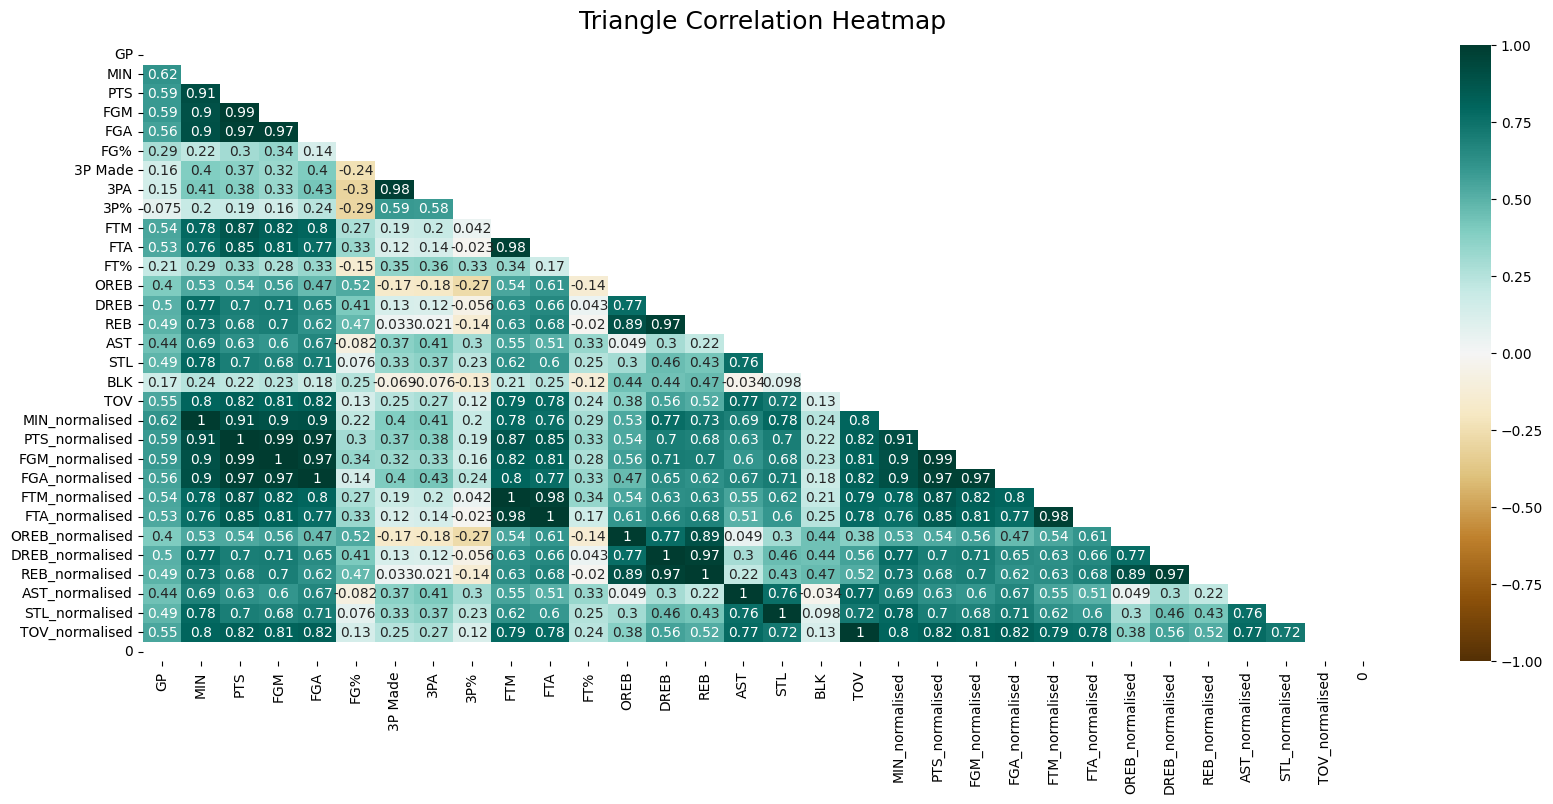

In [655]:
#Let's explore the correlation of the columns in the new training data
print('Triangle Correlation Heatmap - cleaned and stratified training data')
confusionmatrix(new_trainingdata)

In [656]:
#Splitting the training data into test and train
X_data, X_test, y_data, y_test = train_test_split (X, y, test_size=0.2, random_state=8)
#Split the remaining data (80%) randomly with random_state=8 into 2 different sets: training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=8)
#Save the different sets in the folder `data/processed
np.save('../data/processed/X_train', X_train)
np.save('../data/processed/X_val',   X_val)
np.save('../data/processed/X_test',  X_test)
np.save('../data/processed/y_train', y_train)
np.save('../data/processed/y_val',   y_val)
np.save('../data/processed/y_test',  y_test)

<h1> 4. Feature Engineering <h1>

The training data is looking great, the statistics are looking more similar to the test data. Let's remove some highly correlated columns.
<p>There is a high correlation between MIN/PTS/FGM, after experimenting with excluding/including columns, keeping MIN yields the highest ROC
<p>There is a high correlation between 3P Made and 3PA, keeping 3P Made yields the highest ROC
<p>There is a high correlation between FTM and FTA, keeping FTM yields the highest ROC
<p>There is a high correlation between OREB/DREB/REB, keeping REB yields the highest ROC


In [657]:
#Normalising input columns by taking a cube root did not materially improve the accuracy of XGBoost
input_columns_normalised = ['GP', 
            'MIN_normalised', #'PTS', 'FGM', 
            'FG%',
            'FGA_normalised', 
            '3P Made', #'3PA', 
            '3P%',
            'FTM_normalised', #'FTA', 
            'FT%', 
            'REB_normalised', #'OREB', 'DREB',
            'AST_normalised', 'STL_normalised', 'BLK', 'TOV_normalised']

input_columns = ['GP', 
            'MIN', #'PTS', 'FGM', 
            'FG%',
            'FGA', 
            '3P Made', #'3PA', 
            '3P%',
            'FTM', #'FTA', 
            'FT%', 
            'REB', #'OREB', 'DREB',
            'AST', 'STL', 'BLK', 'TOV']

In [658]:
X = X_train[input_columns]
y = y_train

<h1> 5. Model Selection </h1>

<h4> 5.1 Random Forest Classifier with 100 forests with max depth of 4</h4>
<p> Kaggle score 0.71 (improvement of ~2%)

In [659]:
#Let's train the Random Forest Classifier with 150 forests
classifier = RandomForestClassifier(random_state=42, n_estimators=100, max_depth =4)
classifier.fit(X, y) 

RandomForestClassifier(max_depth=4, random_state=42)

In [660]:
dump(classifier,  '../models/randomforest_default.joblib')

['../models/randomforest_default.joblib']

In [661]:
X_train = X_train[input_columns]
X_val = X_val[input_columns]

In [662]:
#Save the predictions from this model for the training and validation sets into 2 variables called y_train_preds and y_val_preds
y_train_preds = classifier.predict(X_train)
pred_probs_val = classifier.predict_proba(X_val)
y_val_preds = classifier.predict(X_val)
pred_probs_val = classifier.predict_proba(X_val)[:,1]

In [663]:
print(pred_probs_val)

[0.86471685 0.84043825 0.88179673 ... 0.82297013 0.8340605  0.82979817]


In [664]:
print(mse(y_val, y_val_preds, squared=False))
print(mae(y_val, y_val_preds))

0.3648198530505928
0.13309352517985612


In [665]:
roc_auc_score(y_val, pred_probs_val)

0.7077212066838623

In [666]:
accuracy_score(y_val, y_val_preds)

0.8669064748201439

In [667]:
X_test = X_test[input_columns]

In [668]:
#Applying this to the test data
y_test_preds = classifier.predict(X_test)
pred_probs_test = classifier.predict_proba(X_test)[:,1]

In [669]:
print(mse(y_test, y_test_preds, squared=False))
print(mae(y_test, y_test_preds))

0.3859026604071972
0.14892086330935253


In [670]:
roc_auc_score(y_val, pred_probs_val)

0.7077212066838623

In [671]:
accuracy_score(y_val, y_val_preds)

0.8669064748201439

In [672]:
def predictivepower(x):
    feature_imp = pd.Series(np.round(100 * x,2), index = X.columns)
    plt.figure(figsize=(8,8))
    feature_imp.nlargest(30).plot(kind='barh', title='Predictive Power% ',fontsize=12)                        
    plt.savefig('features.png', bbox_inches='tight')
    joblibpath = 'model.joblib'
    joblib.dump(classifier, joblibpath, compress=3)

Predictive Power of Random Forest


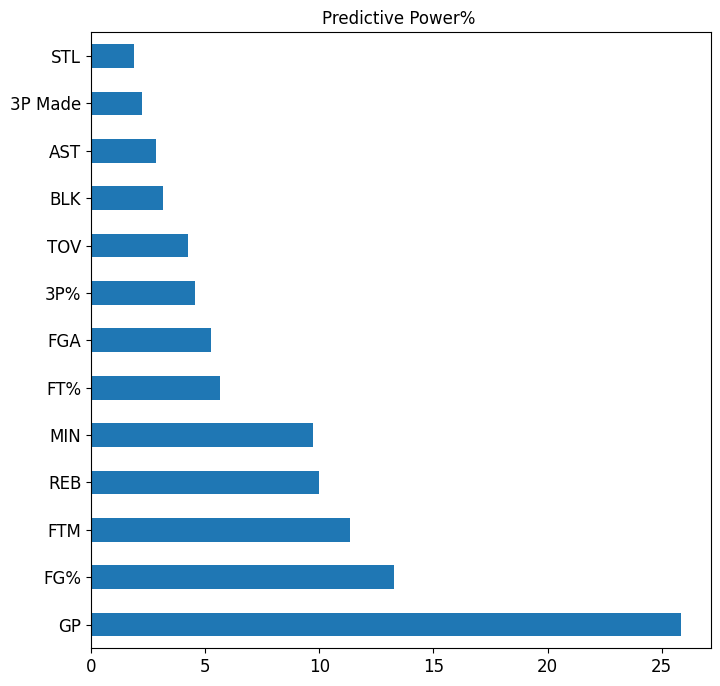

In [673]:
print('Predictive Power of Random Forest')
predictivepower(classifier.feature_importances_)

<h4> 5.2 Let's now try XGBoost with default setting </h4>
<p> Kaggle score 0.66475 (improvement of 0.03)

In [674]:
classifier_2 = XGBClassifier(n_estimators = 100, max_depth = 4)
classifier_2.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Predictive Power of XGBoost with 100 trees and max depth of 4


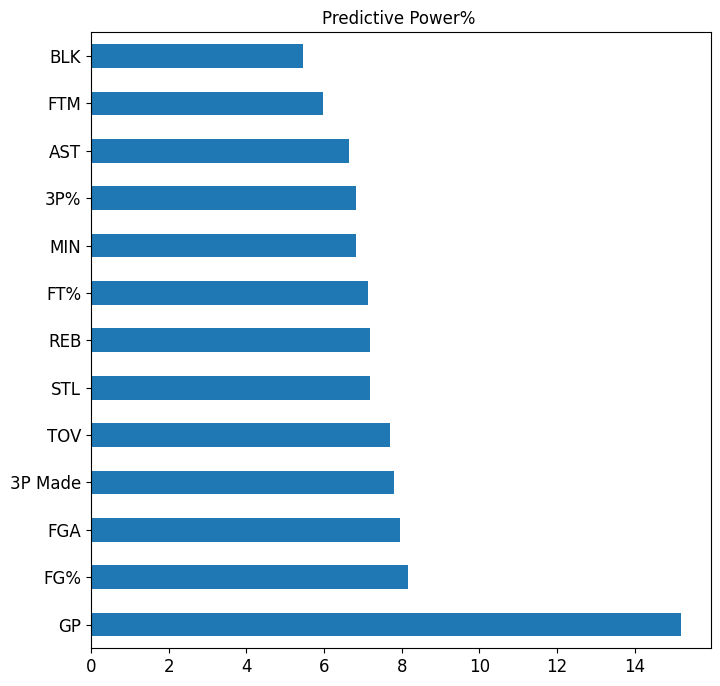

In [675]:
print('Predictive Power of XGBoost with 100 trees and max depth of 4')
predictivepower(classifier_2.feature_importances_)

In [676]:
dump(classifier_2,  '../models/XGBoost_default.joblib')

['../models/XGBoost_default.joblib']

In [677]:
#Applying this to the test data
y_test_preds_XGB = classifier_2.predict(X_test)
pred_probs_test_XGB = classifier_2.predict_proba(X_test)[:,1]
y_val_preds_XGB = classifier_2.predict(X_val)
pred_probs_val_XGB = classifier_2.predict_proba(X_val)[:,1]

In [678]:
print(mse(y_test, y_test_preds_XGB, squared=False))
print(mae(y_test, y_test_preds_XGB))

0.3905355113322101
0.15251798561151078


In [679]:
roc_auc_score(y_test, pred_probs_test_XGB)

0.6704909731665585

In [680]:
accuracy_score(y_val, y_val_preds_XGB)

0.8507194244604317

In [681]:
#Lets try again without deleting any columns
X_train = np.load('../data/processed/X_train.npy')
X_val   = np.load('../data/processed/X_val.npy'  )
X_test  = np.load('../data/processed/X_test.npy' )
y_train = np.load('../data/processed/y_train.npy')
y_val   = np.load('../data/processed/y_val.npy'  )
y_test  = np.load('../data/processed/y_test.npy' )

In [682]:
classifier_2b = XGBClassifier(n_estimators = 300)
classifier_2b.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Predictive Power of XGBoost default method


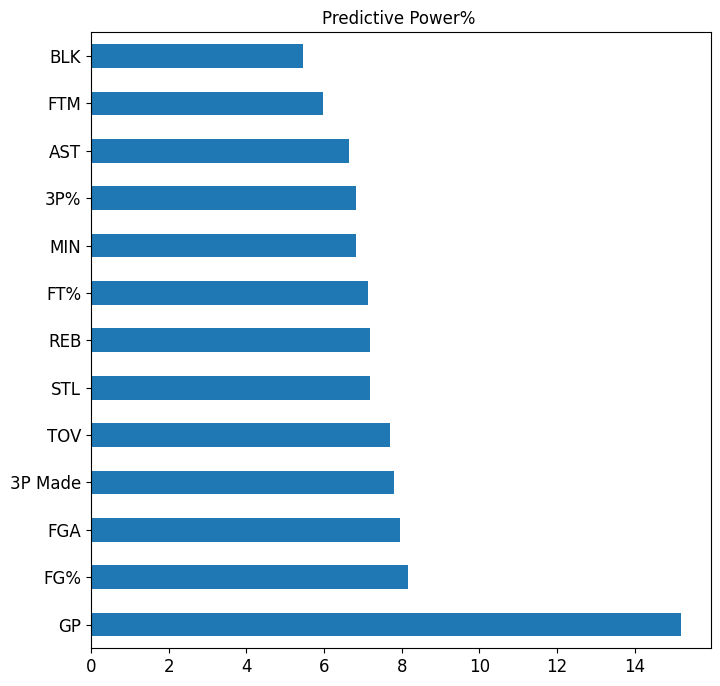

In [683]:
print('Predictive Power of XGBoost default method')
predictivepower(classifier_2.feature_importances_)

In [684]:
#Applying this to the test data
y_test_preds_XGB = classifier_2b.predict(X_test)
pred_probs_test_XGB = classifier_2b.predict_proba(X_test)[:,1]
y_val_preds_XGB = classifier_2b.predict(X_val)
pred_probs_val_XGB = classifier_2b.predict_proba(X_val)[:,1]

In [685]:
print(mse(y_test, y_test_preds_XGB, squared=False))
print(mae(y_test, y_test_preds_XGB))

0.3969306700603172
0.15755395683453238


In [686]:
roc_auc_score(y_test, pred_probs_test_XGB)

0.6637142122091955

In [687]:
accuracy_score(y_val, y_val_preds_XGB)

0.8534172661870504

In [688]:
classifier_3 = RandomForestClassifier(random_state=0, n_estimators=300)
classifier_3.fit(X, y) 

RandomForestClassifier(n_estimators=300, random_state=0)

In [689]:
dump(classifier_3,  '../models/randomforest_normalised.joblib')

['../models/randomforest_normalised.joblib']

In [690]:
X_test=testdata[input_columns]
y_hat = classifier_3.predict_proba(X_test)[:,1]
submission = pd.DataFrame(y_hat)
submission.to_csv("submission_RFnormalised.csv")
